In [1]:
import os
from glob import glob
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

/home/adimyth/.cache/pypoetry/virtualenvs/arya-date-FMMjjJ2d-py3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
TRAIN_PATH = "../data/raw/train/"
TEST_PATH = "../data/raw/test/"

In [3]:
train_files = glob(os.path.join(TRAIN_PATH, "*.png"))
train_labels = pd.read_csv(os.path.join(TRAIN_PATH, "train_data.csv"))

In [4]:
len(train_files), len(train_labels)

(10000, 10000)

In [5]:
test_files = glob(os.path.join(TEST_PATH, "*.png"))
test_labels = pd.read_csv(os.path.join(TEST_PATH, "sample_submission.csv"))

In [6]:
len(test_files), len(test_labels)

(1000, 1000)

## Random Visualization

In [7]:
def plot_grid(files, labels=None, h=6, w=6, title=""):
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    for idx, path in enumerate(random.choices(files, k=h*w)):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, 3)
        image = tf.cast(image/255, tf.float32)
        image_number = path.split("/")[-1].split(".")[0]
        label = labels.loc[labels["tag"]==int(image_number)]["label"].values[0]

        ax[idx // h, idx % w].imshow(image)
        ax[idx // h, idx % w].axis("off")
        ax[idx // h, idx % w].set_title(f"Image: {image_number} Label: {label}")
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

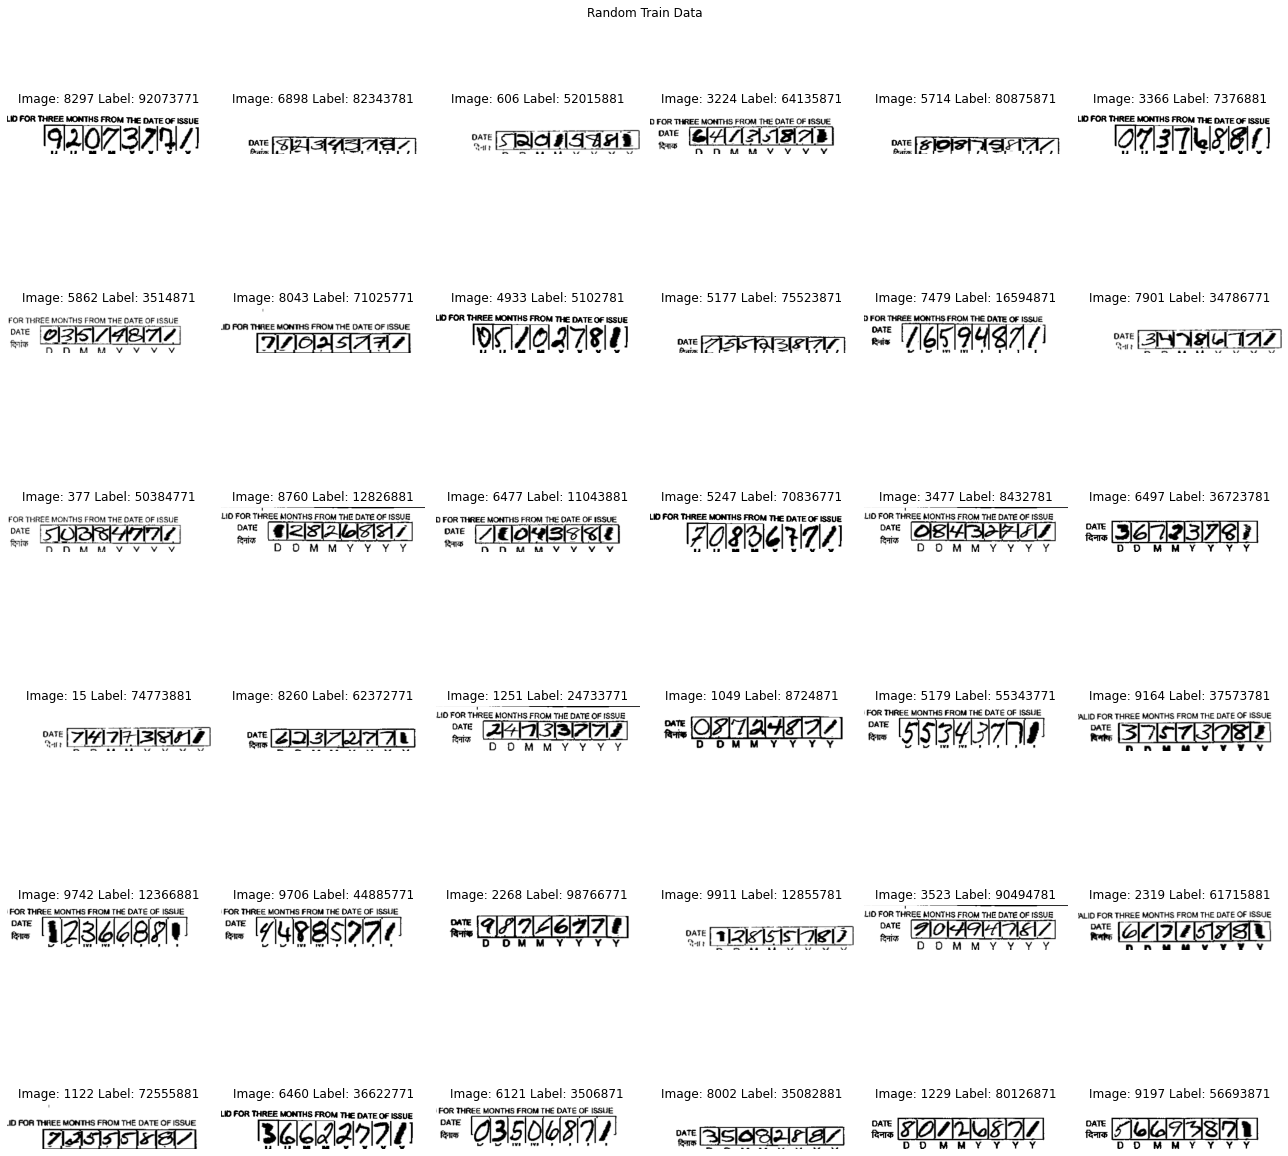

In [8]:
plot_grid(train_files, train_labels, title="Random Train Data")

**These don't look like actual dates in any sense**. Note that all the bottom text says - *DDMMYYYY* for all images

## Train Labels

In [9]:
train_labels["length"] = train_labels["label"].astype(str).str.len()

In [10]:
train_labels["length"].describe()

count    10000.000000
mean         7.892400
std          0.341517
min          5.000000
25%          8.000000
50%          8.000000
75%          8.000000
max          8.000000
Name: length, dtype: float64

**Mean length is not an integer meaning that there are some cases where date is not of the form *DD-MM-YYYY* or label is incorrect**.

In [11]:
diff = train_labels.loc[train_labels["length"]!=8]

In [12]:
diff.shape

(980, 3)

In [13]:
diff.head()

tag    label  length
7   7787   595771       6
13  9896  5034881       7
20  1317  7125871       7
25  7660  7423881       7
45  6086  5442771       7

In [14]:
diff_files = [os.path.join(TRAIN_PATH, f"{x}.png") for x in diff["tag"]]

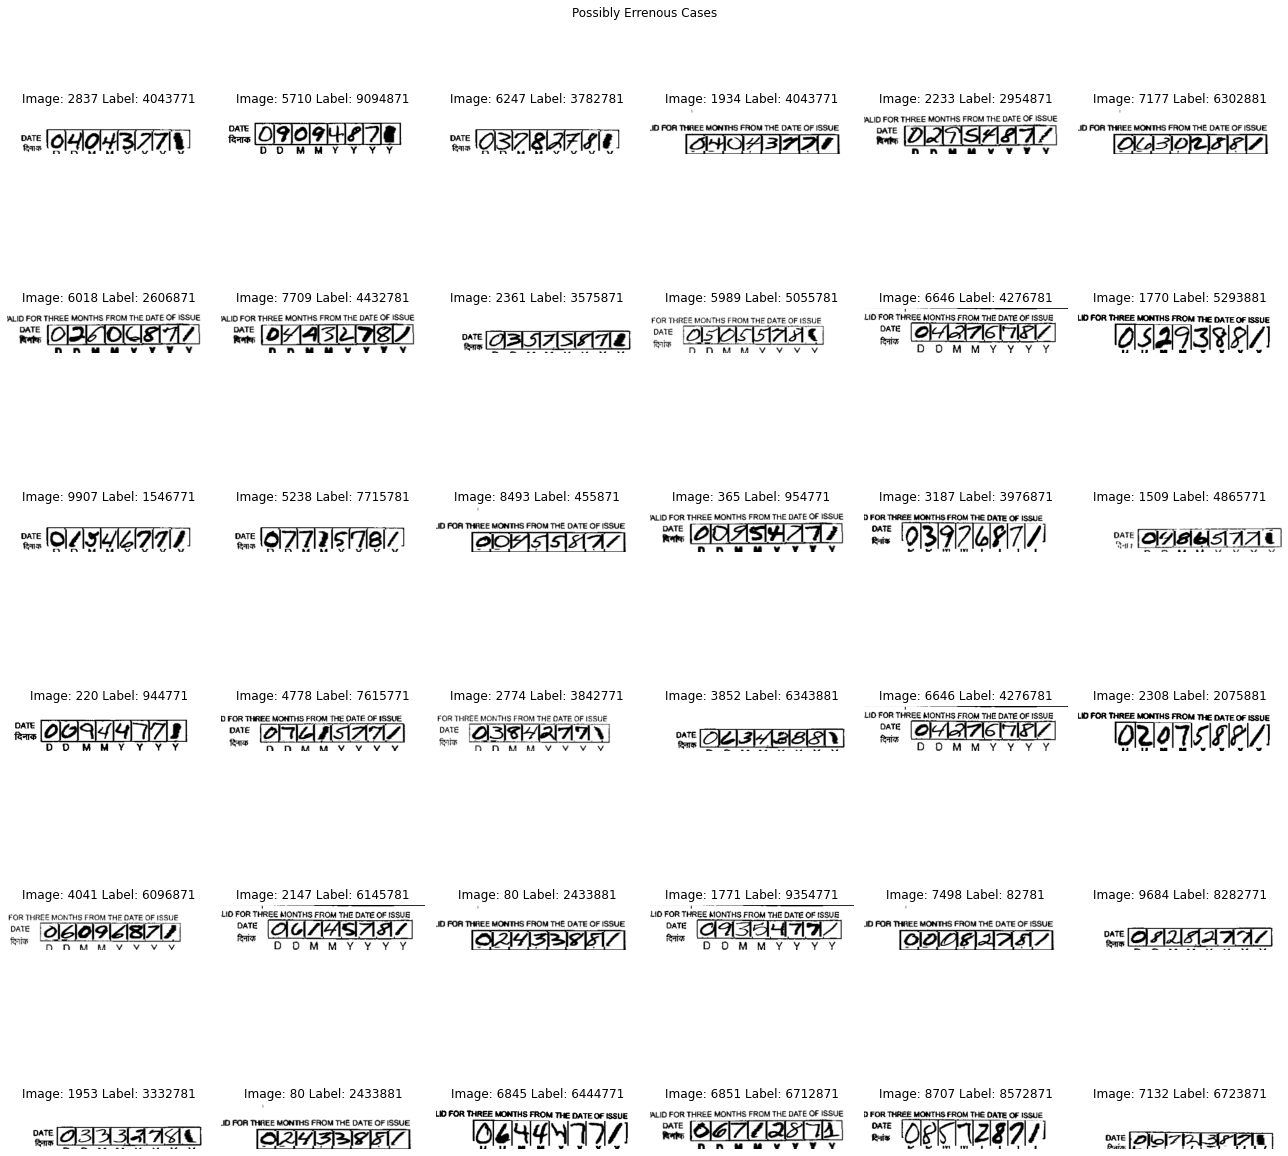

In [15]:
plot_grid(diff_files, train_labels, title="Possibly Errenous Cases")

In [16]:
train_labels["length"].value_counts()

8    9020
7     891
6      82
5       7
Name: length, dtype: int64

**Length 7 - 0 is missing at the start in label**

In [17]:
diff_len_seven = [os.path.join(TRAIN_PATH, f"{x}.png") for x in diff.loc[diff["length"]==7]["tag"]]

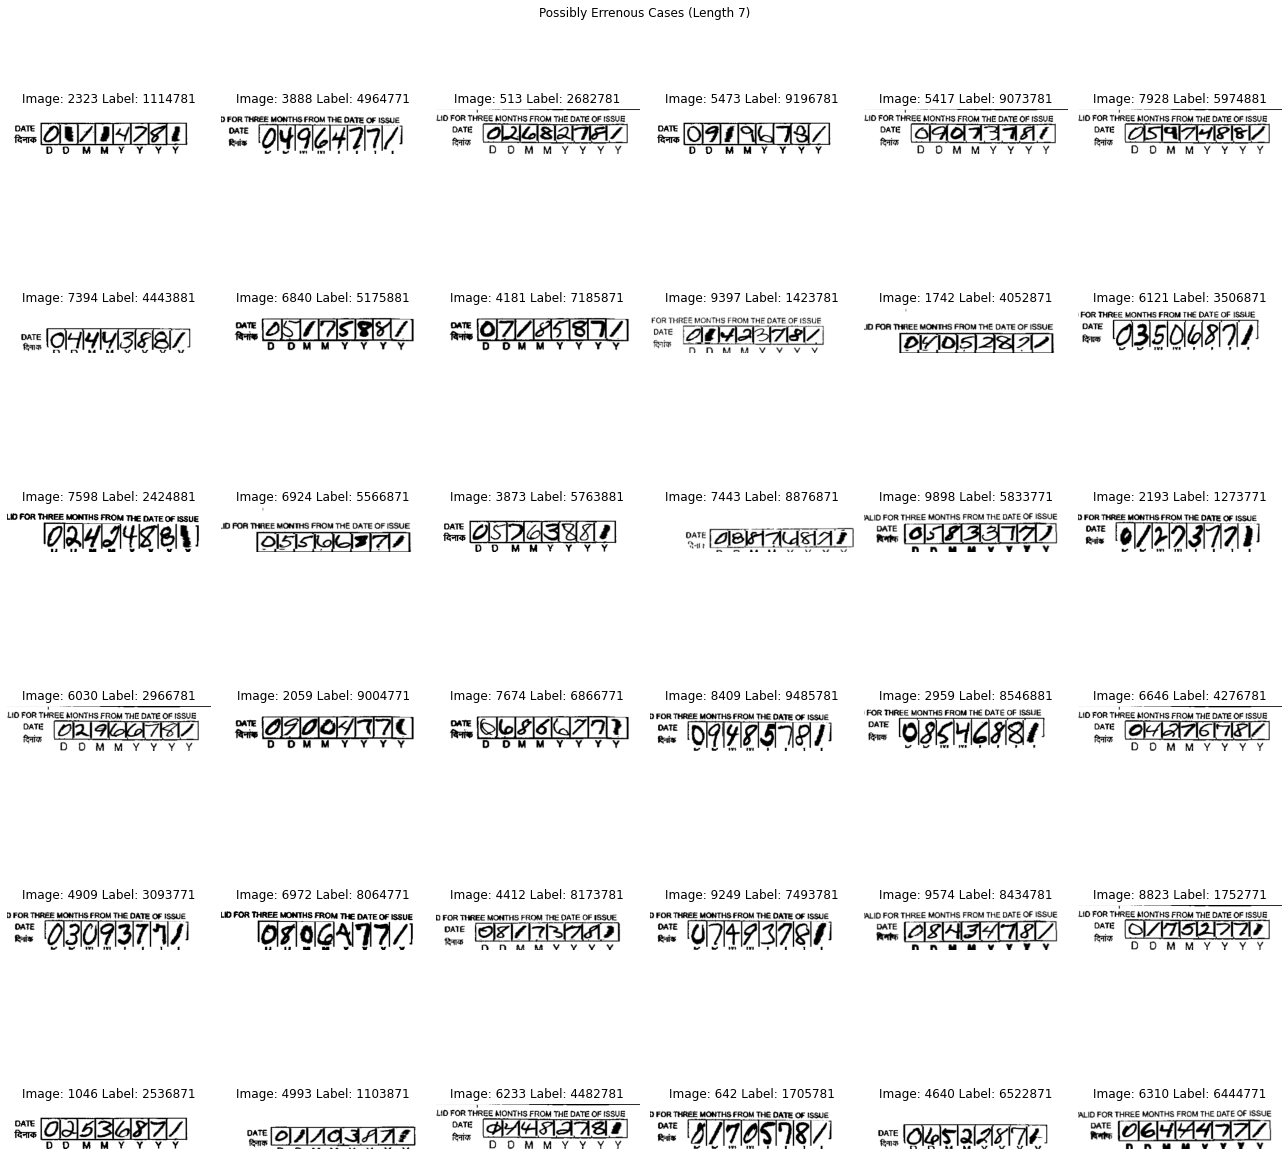

In [18]:
plot_grid(diff_len_seven, train_labels, title="Possibly Errenous Cases (Length 7)")

**Length 6 - Two 0's are missing at the start in label**

In [19]:
diff_len_six = [os.path.join(TRAIN_PATH, f"{x}.png") for x in diff.loc[diff["length"]==6]["tag"]]

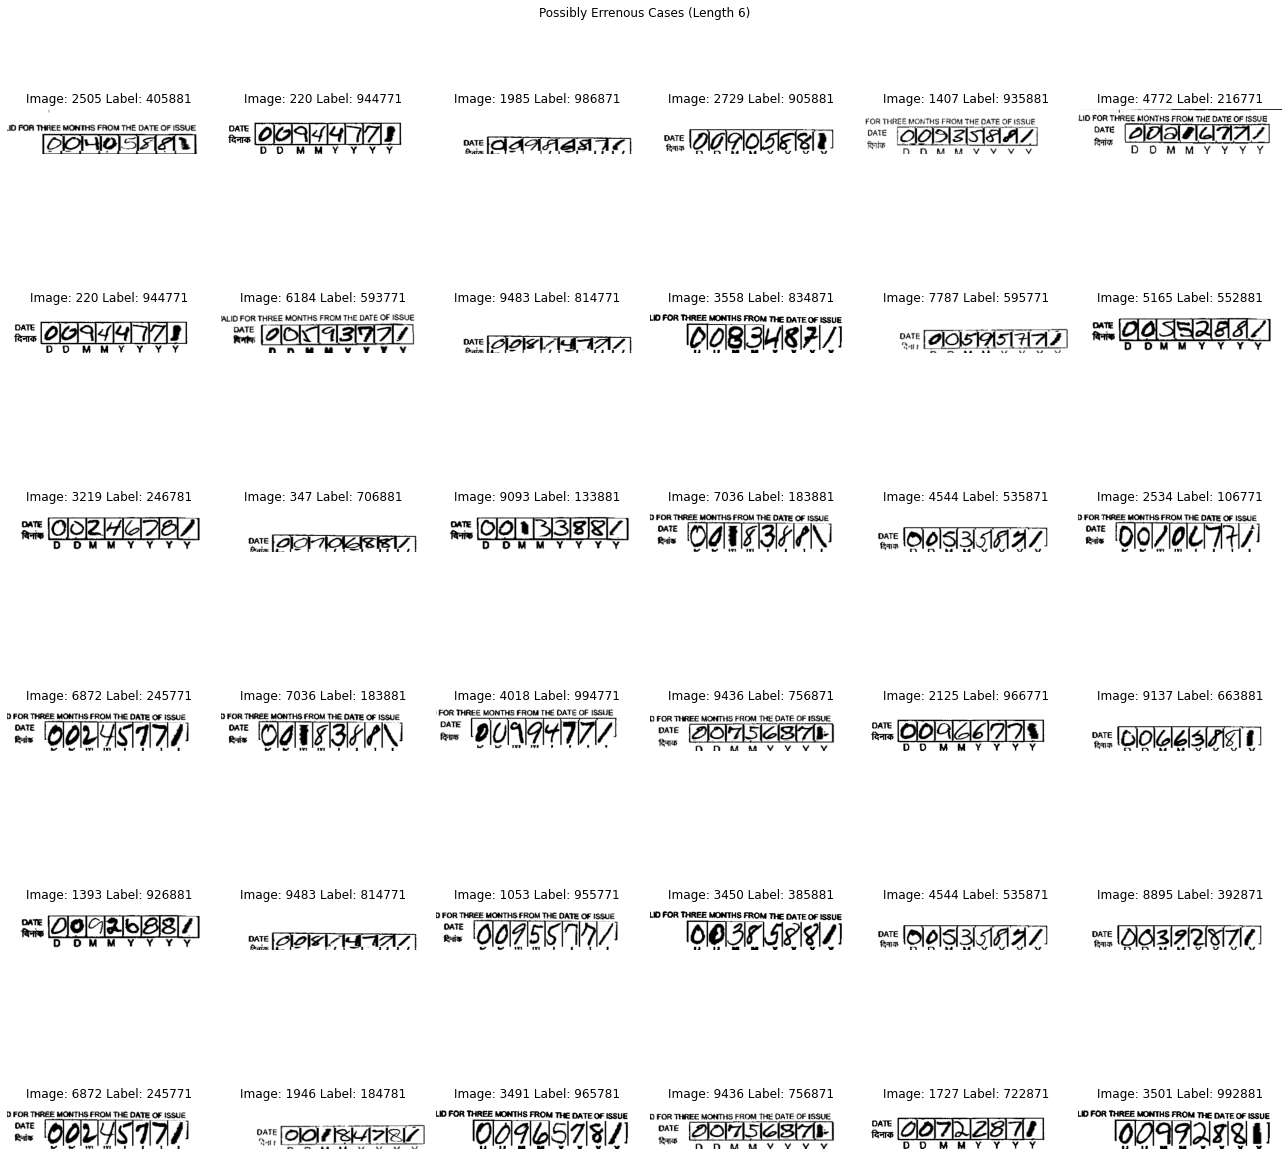

In [20]:
plot_grid(diff_len_six, train_labels, title="Possibly Errenous Cases (Length 6)")

**Length 5 - Three 0's are missing at the start in label**

In [21]:
diff_len_five = [os.path.join(TRAIN_PATH, f"{x}.png") for x in diff.loc[diff["length"]==5]["tag"]]

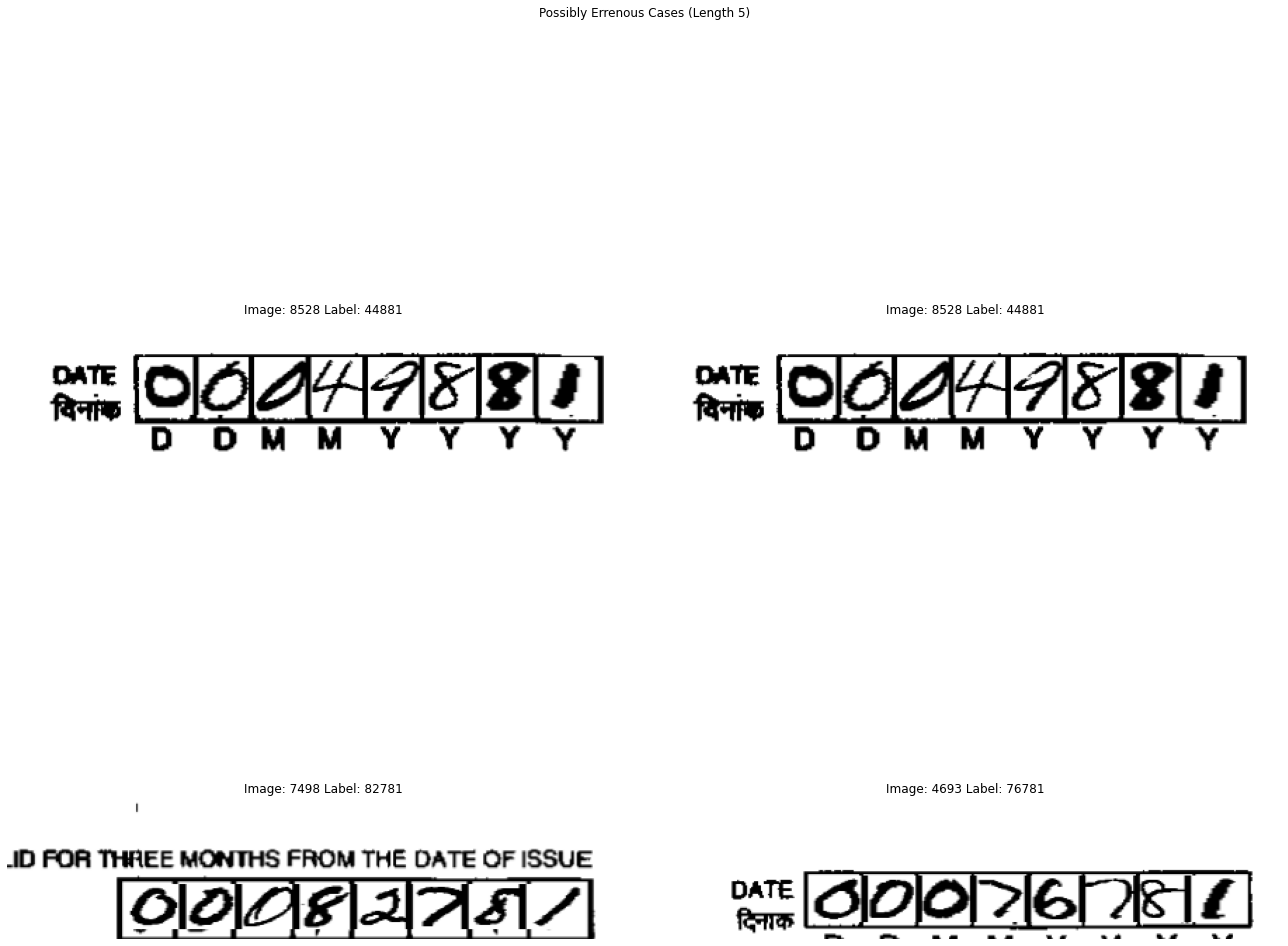

In [22]:
plot_grid(diff_len_five, train_labels, h=2, w=2, title="Possibly Errenous Cases (Length 5)")

In [23]:
train_labels["label"] = train_labels["label"].astype(str).apply(lambda x: x.zfill(8))

In [24]:
train_labels.loc[train_labels["length"]==5].head()

tag     label  length
102   4693  00076781       5
1789  8528  00044881       5
1893  9617  00012881       5
4223  6671  00085781       5
8686  2782  00016881       5

Saving corrected labels as string

In [25]:
train_labels.to_csv(os.path.join(TRAIN_PATH, "corrected_train_data.csv"), index=False)

## Modified Images

### Train

In [26]:
mod_train_files = glob("../data/interim/train/*.png")

In [27]:
len(mod_train_files)

394

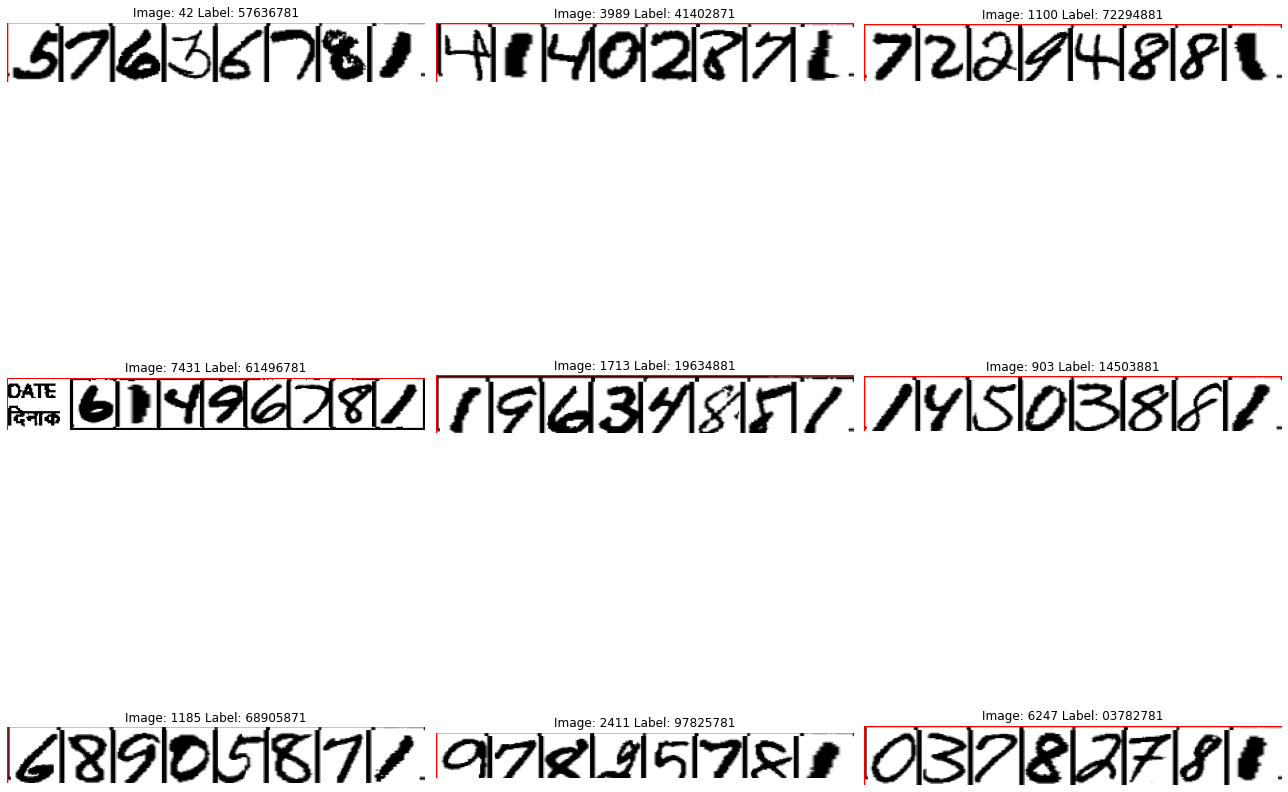

In [28]:
plot_grid(mod_train_files, train_labels, h=3, w=3)

**Modified Errenous**

In [29]:
mod_train_err_files = glob("../data/interim/train_errenous/*.png")

In [30]:
len(mod_train_err_files)

9606

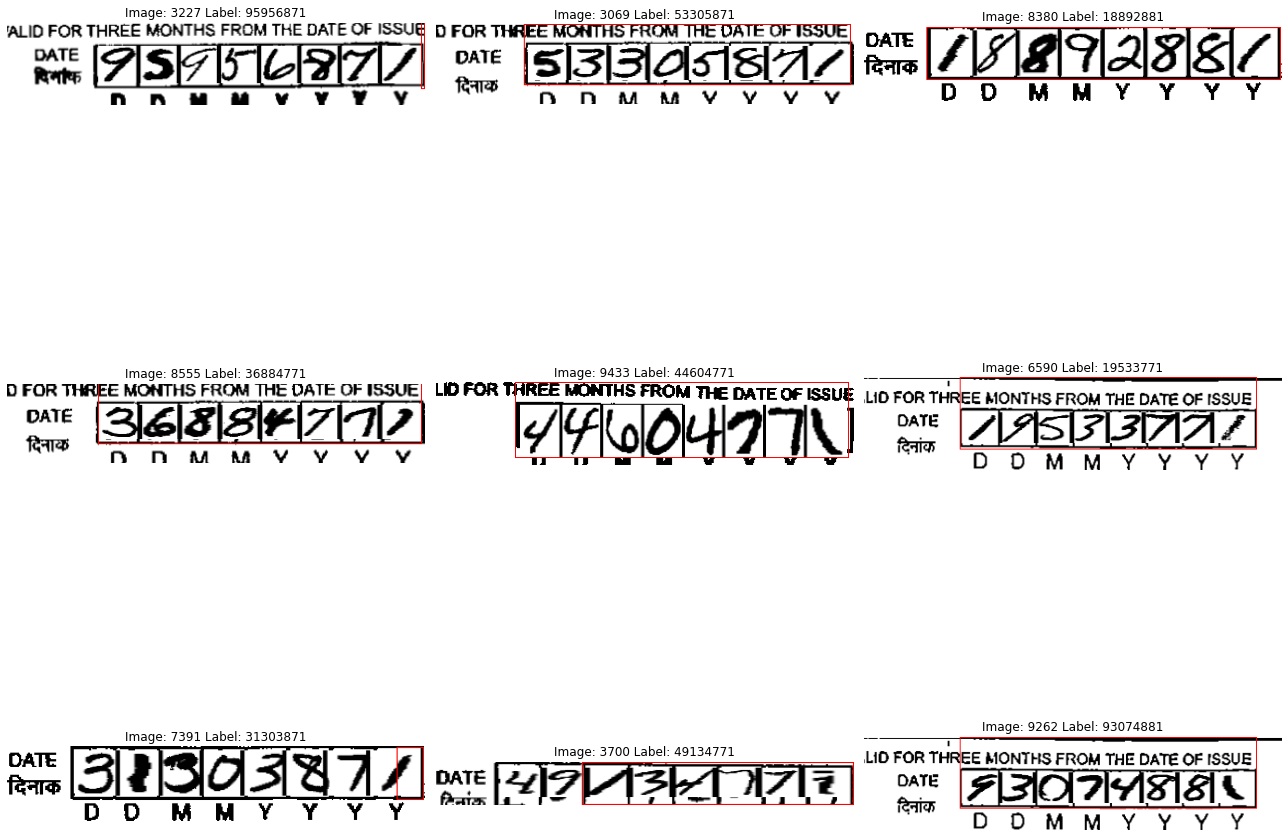

In [31]:
plot_grid(mod_train_err_files, train_labels, h=3, w=3)

### Test

In [32]:
mod_test_files = glob("../data/interim/test/*.png")

In [33]:
len(mod_test_files)

40

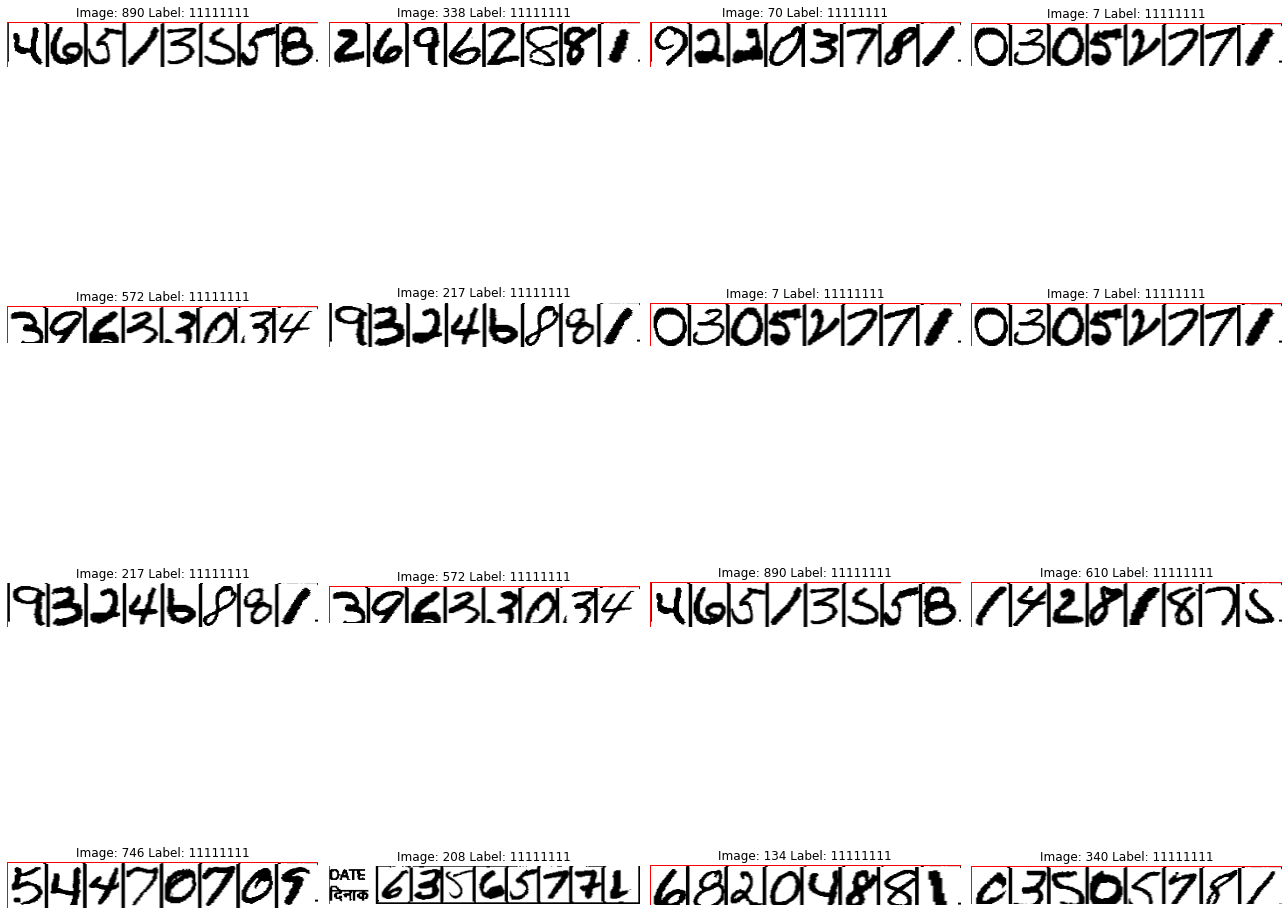

In [34]:
plot_grid(mod_test_files, test_labels, h=4, w=4)

**Modified Errenous**

In [35]:
mod_test_err_files = glob("../data/interim/test_errenous/*.png")

In [36]:
len(mod_test_err_files)

960

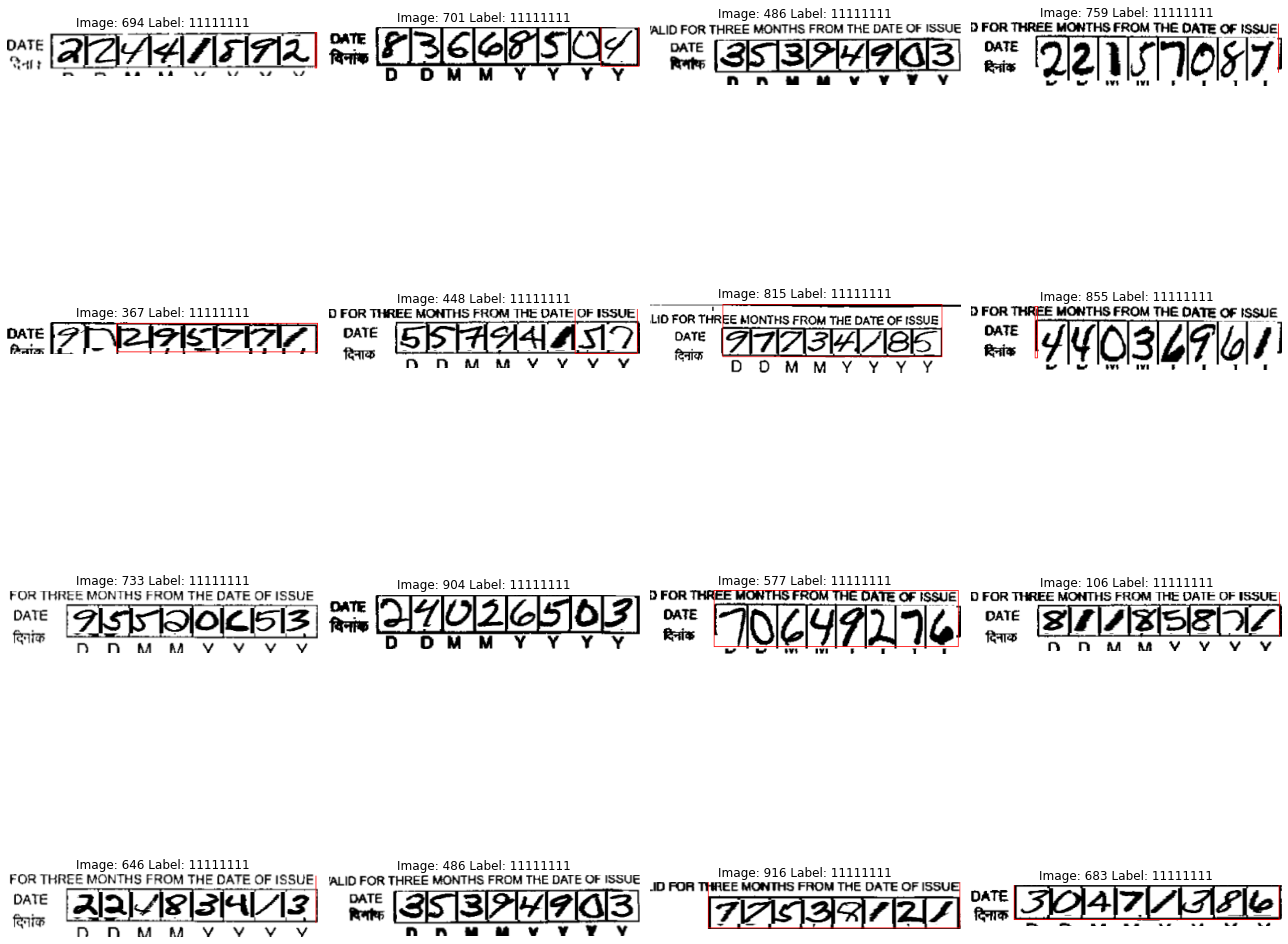

In [37]:
plot_grid(mod_test_err_files, test_labels, h=4, w=4)

## Processed Images

**Modified cases above are sliced so as to save dates only**. Errenous cases are stored as it is.

### Train

In [38]:
processed_train_files = glob("../data/processed/train/*.png")

In [39]:
len(processed_train_files)

10000

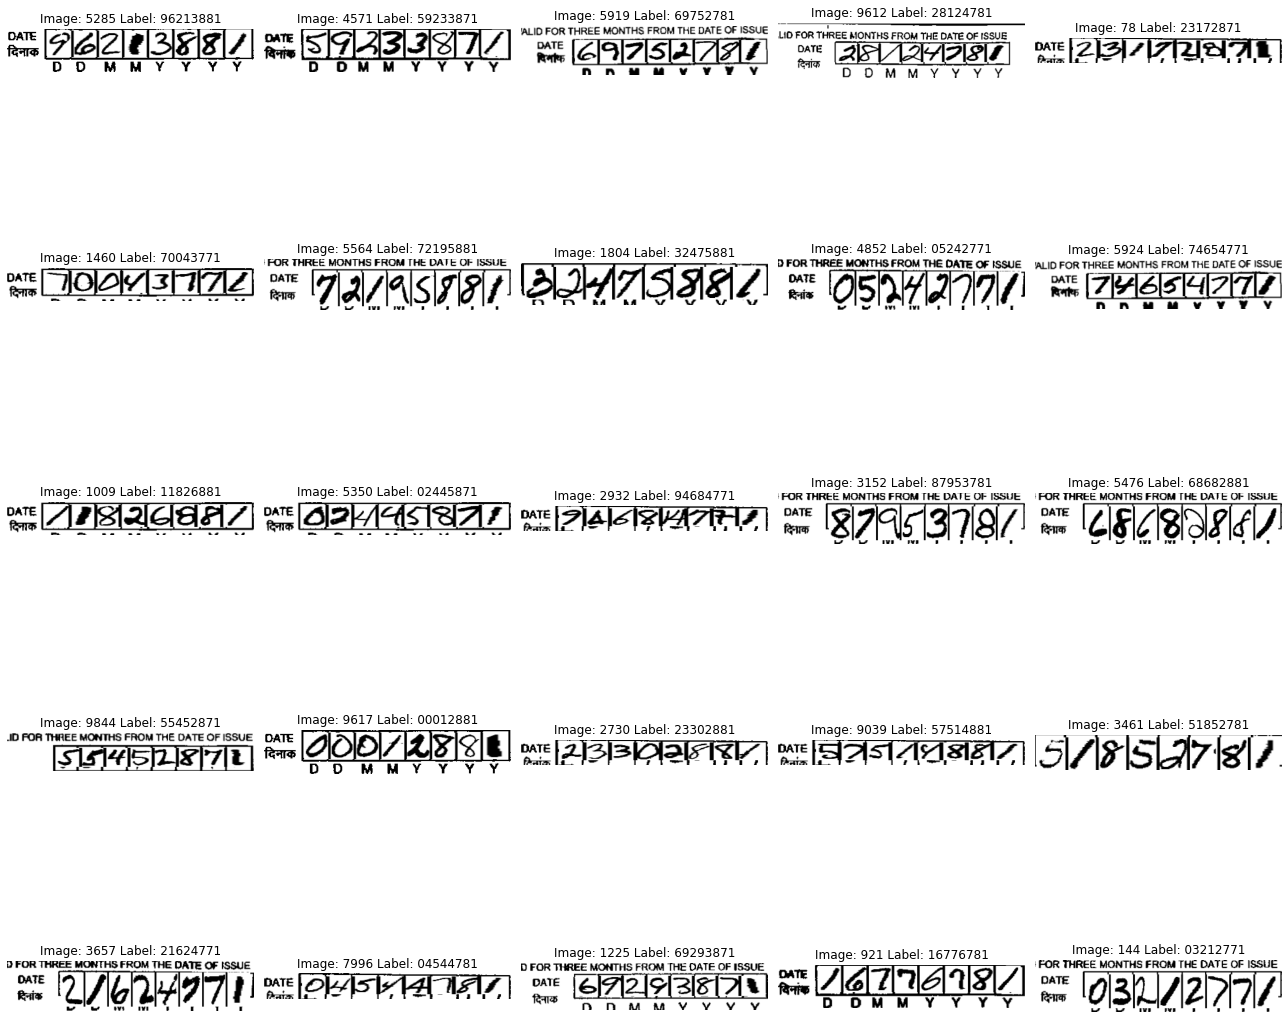

In [40]:
plot_grid(processed_train_files, train_labels, h=5, w=5)

### Test

In [41]:
processed_test_files = glob("../data/processed/test/*.png")

In [42]:
len(processed_test_files)

1000

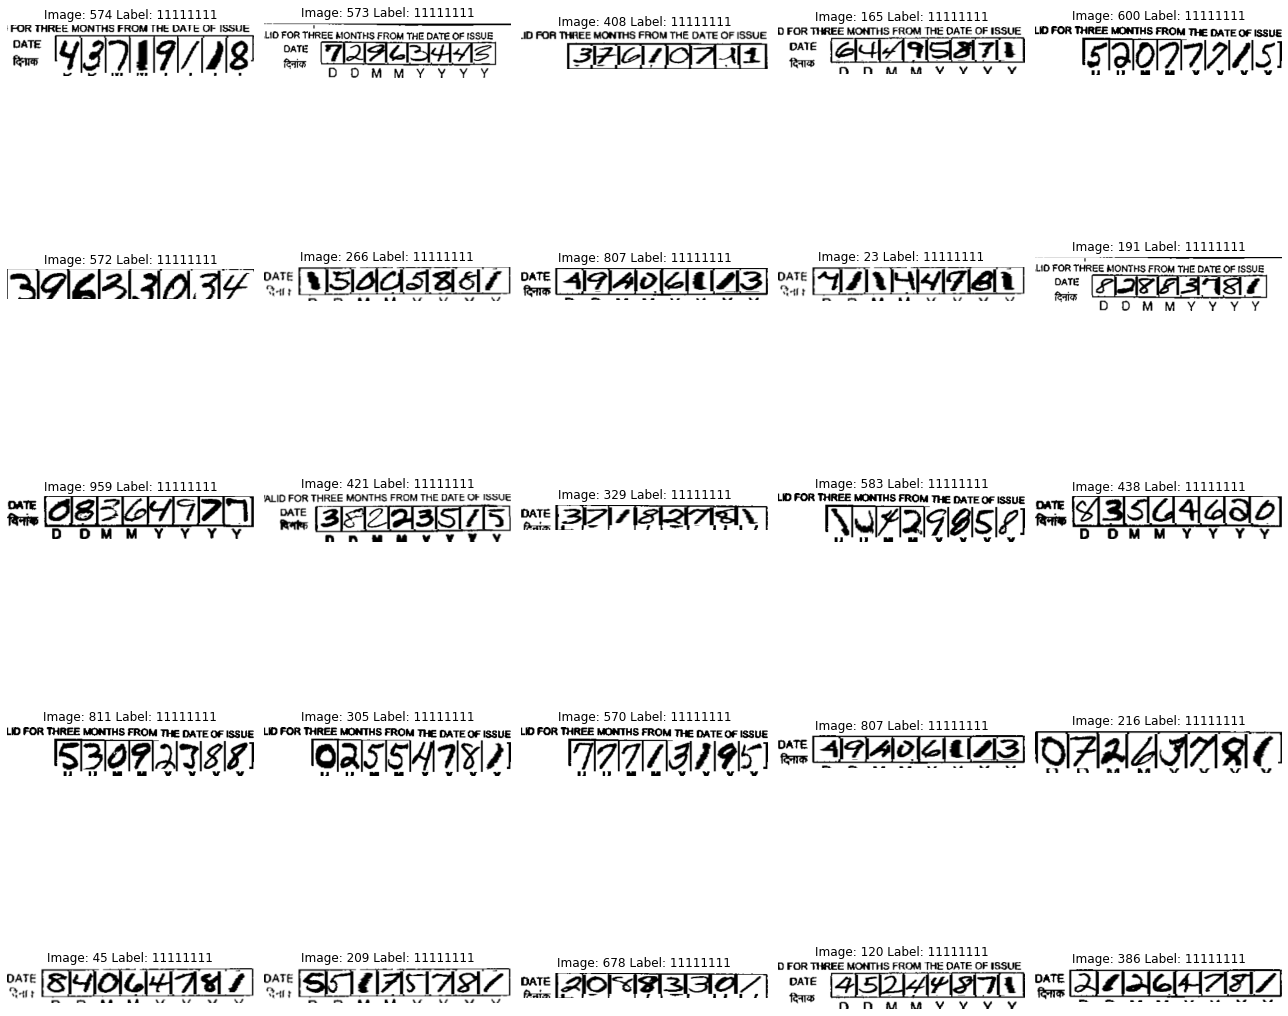

In [43]:
plot_grid(processed_test_files, test_labels, h=5, w=5)

## Digits distribution

In [57]:
for i in range(10):
    train_labels[i] = train_labels["label"].str.count(str(i))

In [58]:
train_labels.head()

tag     label  length  0  1  2  3  4  5  6  7  8  9
0  2531  17454871       8  0  2  0  0  2  1  0  2  1  0
1  2351  34053871       8  1  1  0  2  1  1  0  1  1  0
2  2763  70164781       8  1  2  0  0  1  0  1  2  1  0
3  9024  24245771       8  0  1  2  0  2  1  0  2  0  0
4  7368  94895871       8  0  1  0  0  1  1  0  1  2  2

In [59]:
for i in range(10):
    print(f"{i} - {train_labels[i].sum()}")

0 - 3979
1 - 14021
2 - 5898
3 - 6022
4 - 6074
5 - 6041
6 - 5812
7 - 14021
8 - 14155
9 - 3977


In [75]:
train_labels["label"].str[-3:].value_counts()

881    2557
871    2505
781    2470
771    2468
Name: label, dtype: int64

Digits 1,7 & 8 occur the most. Infact they occur multiple times compared to other digits and always form a triplet at the end of the number. Will that be the scenario in real life?

**However this doesn't seem to be the case with test images**

In [85]:
err = [413, 487, 512, 572, 
       605, 625, 634, 655, 
       771, 773, 801, 816, 
       869, 882]

In [86]:
err_files = [f"../data/processed/test/{x}.png" for x in err]

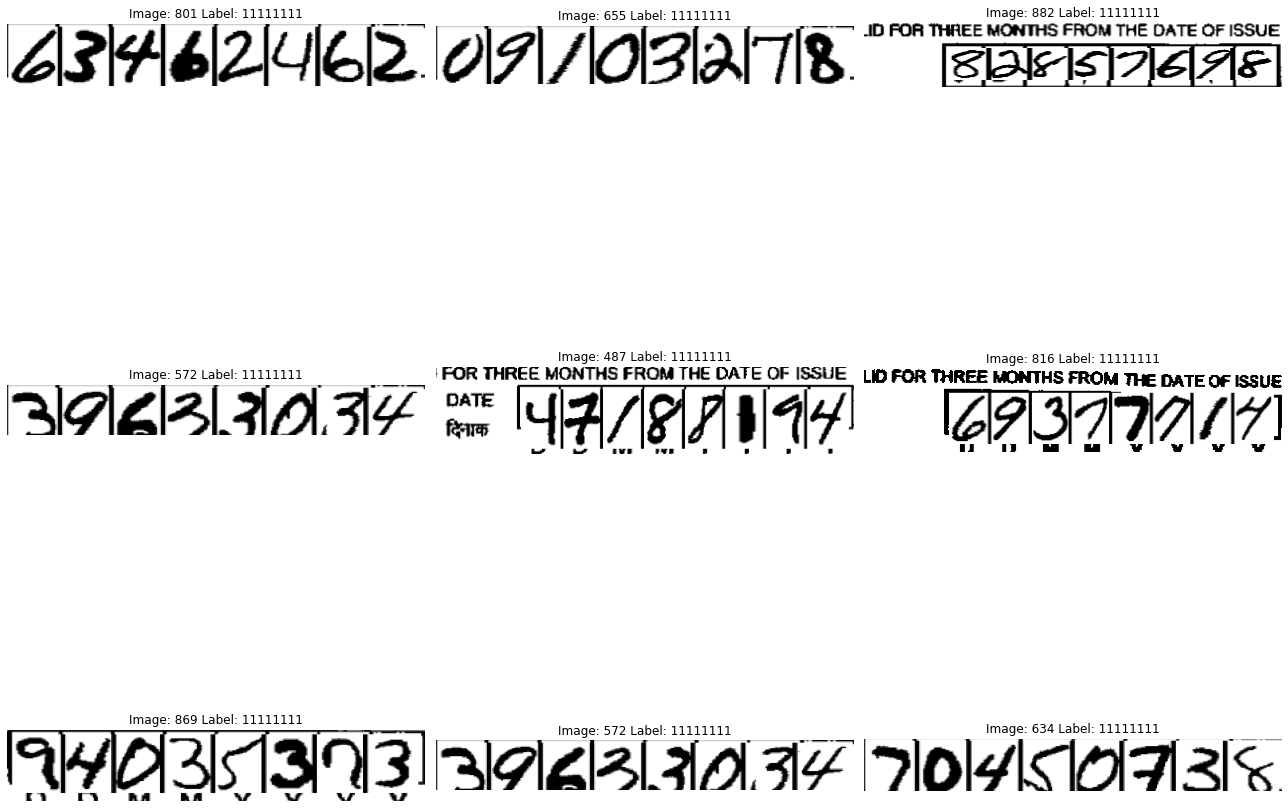

In [88]:
plot_grid(err_files, test_labels, h=3, w=3)